In [50]:
%load_ext autoreload
%autoreload 2

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from cvae_featurization import *
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from cvae import TempTimeGenerator
from hyperopt import fmin, tpe, hp, STATUS_OK
import re

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
imputation_strategy="mp_fraction"
featurization="mp_fraction"
only_ss_rxns, ss_precursor_nomenclature = impute_data(imputation_strategy)
df, prec_magpie_feats = featurize(featurization, only_ss_rxns, ss_precursor_nomenclature)

Returning extracted data of 51574/31782 reactions.


100%|██████████| 51574/51574 [00:35<00:00, 1447.11it/s]


In [17]:
objective = "temp_time_vector"
omit_columns = ['targets', 'precursors', objective, 'composition_obj']
X_columns = [x for x in df.columns if x not in omit_columns]
y_column = objective
X_df = df[X_columns]
X_columns = list(X_df.columns)
X = X_df.values
y = df[y_column].values

X, y, prec_magpie_feats, full_df = shuffle(X, y, prec_magpie_feats, df, random_state=42)

y = np.vstack(y)
print("Shape of X: {}".format(X.shape))
print("Shape of y: {}".format(y.shape))

Shape of X: (26469, 103)
Shape of y: (26469, 8)


In [18]:
# hyperparameter tuning
rnn_dim = [16, 32, 64]
conv_filters = [8, 16, 32]
intermediate_dim = [64, 128, 256]
latent_dim = [3, 4, 5, 6]

orig_parameters = {
    'rnn_dim': rnn_dim,
    'conv_filters': conv_filters,
    'intermediate_dim': intermediate_dim,
    'latent_dim': latent_dim
}

# create the random grid
parameters = {
    'rnn_dim': hp.choice('rnn_dim', rnn_dim),
    'conv_filters': hp.choice('conv_filters', conv_filters),
    'intermediate_dim': hp.choice('intermediate_dim', intermediate_dim),
    'latent_dim': hp.choice('latent_dim', latent_dim)
}

def objective(parameters):
    temp_gen = TempTimeGenerator()
    temp_gen.build_nn_model(rnn_dim=parameters['rnn_dim'], 
    conv_filters=parameters['conv_filters'],
    intermediate_dim=parameters['intermediate_dim'],
    latent_dim=parameters['latent_dim'],
    precursor_len=prec_magpie_feats.shape[-1])

    callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')]
    history = temp_gen.train(
        inputs=train_inputs, 
        outputs=train_outputs,
        epochs=500,
        val_split=0,
        val_data=val_data,
        batch_size=128,
        callbacks=callbacks,
        verbose=2
    )

    # return {'loss': history['val_loss'][-1], 'status': STATUS_OK}
    results = []
    for i in unique_inds_val:
        conds = temp_gen.generate_samples(target_material=X_val[i:i+1], precursors=prec_magpie_feats_val[i:i+1], n_samples=100)
        curr_results = []
        for conditions in conds:
            temp_time = scaler.inverse_transform(conditions.reshape(1, -1)).flatten()
            curr_results.append(temp_time)
        curr_results = np.vstack(curr_results)
        results.append(curr_results)
    results = np.array(results)

    y_pred = np.mean(results, axis=1)
    y_true = np.vstack([np.mean(x['temp_time_vector'], axis=0) for x in val_results])
    rmse_to_minimize = []
    for i in [0, 1, 3, 4]:
        rmse_to_minimize.append(mean_squared_error(y_true[:, i], y_pred[:, i], squared=False))

    del temp_gen


    return {'loss': np.mean(rmse_to_minimize), 'status': STATUS_OK}

best_params = []
y_pred_train, y_pred_test = [], []
X_train_k, X_test_k = [], []
y_train_k, y_test_k = [], []
X_train_df, X_test_df = [], []
n_pts_train_k, n_pts_test_k = [], []
histories = []

In [19]:
def get_unique_test_set(df):
    test_results = []
    unique_inds = []
    for i, (target, precs, temps) in enumerate(zip(df['targets'], df['precursors'], df['temp_time_vector'])):
        found = False
        for result in test_results:
            if result["Target"] == target and set(result["Precursors"]) == set(precs):
                result["temp_time_vector"].append(temps)
                found = True
        if not found:
            new_result = {}
            new_result["Target"] = target
            new_result["Precursors"] = precs
            new_result["temp_time_vector"] = [temps]
            test_results.append(new_result)
            unique_inds.append(i)
    return test_results, np.array(unique_inds)

In [20]:
X_train = X
y_train = y
prec_magpie_feats_train = prec_magpie_feats
df_train = df

X_train_curr, X_val, y_train_curr, y_val, prec_magpie_feats_train_curr, prec_magpie_feats_val, _, df_val = train_test_split(X_train, y_train, prec_magpie_feats_train, df_train, test_size=0.2, shuffle=False)

scaler = StandardScaler()
scaler.fit(X_train_curr)
X_train_curr = scaler.transform(X_train_curr)
X_val = scaler.transform(X_val)

scaler = StandardScaler()
scaler.fit(prec_magpie_feats_train_curr)
prec_magpie_feats_train_curr = scaler.transform(prec_magpie_feats_train_curr)
prec_magpie_feats_val = scaler.transform(prec_magpie_feats_val)

scaler = StandardScaler()
scaler.fit(y_train_curr)
y_train_curr = scaler.transform(y_train_curr)
y_val = scaler.transform(y_val)

y_train_curr = np.reshape(y_train_curr, (-1, 8, 1))
y_val = np.reshape(y_val, (-1, 8, 1))

train_inputs = [y_train_curr, X_train_curr, prec_magpie_feats_train_curr]
train_outputs = [y_train_curr]

val_data = [[y_val, X_val, prec_magpie_feats_val], y_val]

# hyperparameter search
val_results, unique_inds_val = get_unique_test_set(df_val)

# best_parameters = fmin(fn=objective, space=parameters, algo=tpe.suggest, max_evals=25)
best_parameters = None

# convert index to value
# for key in best_parameters:
#     best_parameters[key] = orig_parameters[key][best_parameters[key]]

temp_gen = TempTimeGenerator()
temp_gen.build_nn_model(
#     rnn_dim=best_parameters['rnn_dim'],
#     conv_filters=best_parameters['conv_filters'],
#     intermediate_dim=best_parameters['intermediate_dim'],
#     latent_dim=best_parameters['latent_dim'],
    precursor_len=prec_magpie_feats.shape[-1])
callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')]
history = temp_gen.train(
    inputs=train_inputs, 
    outputs=train_outputs,
    epochs=500,
    val_split=0,
    val_data=val_data,
    batch_size=128,
    callbacks=callbacks,
    verbose=2
)

histories.append(history)

epochs = len(history['val_loss'])

best_params.append([best_parameters, epochs])

del temp_gen

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

scaler = StandardScaler()
scaler.fit(prec_magpie_feats_train)
prec_magpie_feats_train = scaler.transform(prec_magpie_feats_train)

scaler = StandardScaler()
scaler.fit(y_train)
y_train = scaler.transform(y_train)
y_train = np.reshape(y_train, (-1, 8, 1))

train_inputs = [y_train, X_train, prec_magpie_feats_train]
train_outputs = [y_train]

temp_gen = TempTimeGenerator()
temp_gen.build_nn_model(
#     rnn_dim=best_parameters['rnn_dim'],
#     conv_filters=best_parameters['conv_filters'],
#     intermediate_dim=best_parameters['intermediate_dim'],
#     latent_dim=best_parameters['latent_dim'],
    precursor_len=prec_magpie_feats.shape[-1])

history = temp_gen.train(
    inputs=train_inputs, 
    outputs=train_outputs,
    epochs=epochs,
    val_split=0,
    val_data=None,
    batch_size=128,
    callbacks=None,
    verbose=2
)

Train on 21175 samples, validate on 5294 samples
Epoch 1/500
 - 5s - loss: 6.9183 - mean_squared_error: 0.8394 - val_loss: 6.1471 - val_mean_squared_error: 0.7266
Epoch 2/500
 - 3s - loss: 5.8351 - mean_squared_error: 0.6756 - val_loss: 5.4810 - val_mean_squared_error: 0.6218
Epoch 3/500
 - 3s - loss: 5.5602 - mean_squared_error: 0.6254 - val_loss: 5.3587 - val_mean_squared_error: 0.5962
Epoch 4/500
 - 3s - loss: 5.4331 - mean_squared_error: 0.6049 - val_loss: 5.3886 - val_mean_squared_error: 0.5924
Epoch 5/500
 - 3s - loss: 5.1446 - mean_squared_error: 0.5695 - val_loss: 5.2378 - val_mean_squared_error: 0.5876
Epoch 6/500
 - 3s - loss: 5.1477 - mean_squared_error: 0.5684 - val_loss: 5.0603 - val_mean_squared_error: 0.5488
Epoch 7/500
 - 3s - loss: 5.0219 - mean_squared_error: 0.5442 - val_loss: 4.9629 - val_mean_squared_error: 0.5356
Epoch 8/500
 - 3s - loss: 4.8708 - mean_squared_error: 0.5192 - val_loss: 4.7811 - val_mean_squared_error: 0.5064
Epoch 9/500
 - 3s - loss: 4.8204 - mean

In [7]:
# temp_gen.save_models(model_variant=imputation_strategy+"_"+featurization+"_default_hyperparameter", save_path="/home/synthesis-generation/bin/CJK/paper/")

In [30]:
temp_gen = TempTimeGenerator()
temp_gen.build_nn_model(precursor_len=prec_magpie_feats.shape[-1])
temp_gen.load_models(model_variant=imputation_strategy+"_"+featurization+"_default_hyperparameter", load_path="/home/synthesis-generation/bin/CJK/paper/")

In [31]:
target_scaler = StandardScaler()
target_scaler.fit(X)
prec_scaler = StandardScaler()
prec_scaler.fit(prec_magpie_feats)
scaler = StandardScaler()
scaler.fit(y)

StandardScaler()

In [32]:
to_predict = [
    {
        'target': 'Li4Fe7O12',
        'precursors': ['Fe3O4', 'Li2CO3'],
        'temp_time_vector': None
    },
    {
        'target': 'Li4Fe7O12',
        'precursors': ['Fe2O3', 'Li2CO3'],
        'temp_time_vector': None
    },
    {
        'target': 'Li4Fe7O12',
        'precursors': ['Fe(NO3)3', 'Li2CO3'],
        'temp_time_vector': None
    },
    {
        'target': 'Li4Fe7O12',
        'precursors': ['FePO4', 'Li2CO3'],
        'temp_time_vector': None
    },
    {
        'target': 'Li4Fe7O12',
        'precursors': ['FeC2O4', 'Li2CO3'],
        'temp_time_vector': None
    },

]
query_df, query_prec_magpie_feats = add_mp_fraction_feats(to_predict, objective="temp_time_vector")

In [33]:
query_prec_magpie_feats = prec_scaler.transform(query_prec_magpie_feats)

In [34]:
query_target_feats = target_scaler.transform(query_df[X_columns].values)

In [35]:
query_results = []
for i in range(len(query_target_feats)):
    conds = temp_gen.generate_samples(target_material=query_target_feats[i:i+1], precursors=query_prec_magpie_feats[i:i+1], n_samples=1000)
    curr_results = []
    for conditions in conds:
        temp_time = scaler.inverse_transform(conditions.reshape(1, -1)).flatten()
        curr_results.append(temp_time)
    curr_results = np.vstack(curr_results)
    query_results.append(curr_results)
query_results = np.array(query_results)


In [53]:
targets_to_plot = [x['target'] for x in to_predict]
precursors_to_plot = [x['precursors'] for x in to_predict]
targets_to_plot = clean_formulas(targets_to_plot)
precursors_to_plot = [clean_formulas(x) for x in precursors_to_plot]

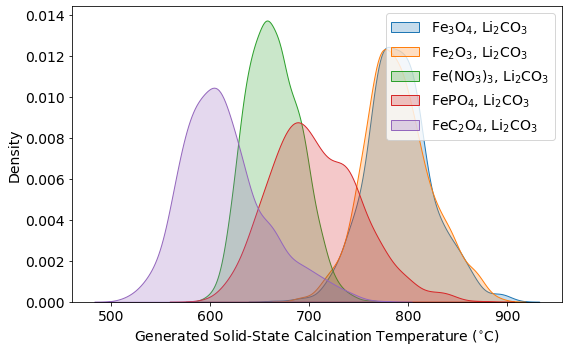

In [57]:
fig, ax = plt.subplots(figsize=(8, 5))
labels = []
for i in range(len(query_results)):
    sns.kdeplot(query_results[i][:, 0], fill=True)
    #sns.kdeplot(result["sinter_temps"], fill=True)
    label = ", ".join(precursors_to_plot[i])
    labels.append(label)
ax.set_xlabel("Generated Solid-State Calcination Temperature $(^{\circ}$C)", fontsize=14)
ax.set_ylabel("Density", fontsize=14)

ax.legend(labels, loc="upper right", fontsize=14)
# ax.set_xlim(500, 1000)
# ax.set_yticks(np.linspace(0, 0.016, 5))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig.tight_layout()
# fig.savefig('/home/jupyter/CJK/CVAE/ceder_imputed/all_targets/neurips_paper/figures/ss_precursor_calcine_sensitivity.png', dpi=200)

In [51]:
def clean_formulas(formula_list):
    chem_list = [re.sub("([0-9]+(\.[0-9]+)?)", "_{\\1}", k) for k in formula_list]
    chem_list = ['$\mathregular{'+list_k+'}$' for list_k in chem_list]
    return chem_list

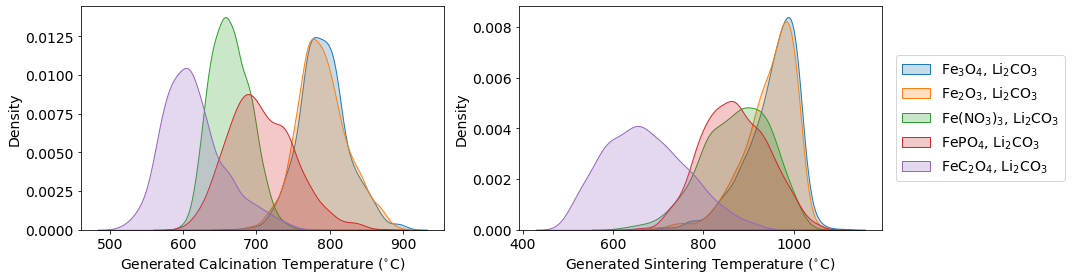

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
labels = []
for i in range(len(query_results)):
    sns.kdeplot(query_results[i][:, 0], fill=True, ax=ax[0])
    #sns.kdeplot(result["sinter_temps"], fill=True)
    label = ", ".join(precursors_to_plot[i])
    labels.append(label)
ax[0].set_xlabel("Generated Calcination Temperature $(^{\circ}$C)", fontsize=14)
ax[0].set_ylabel("Density", fontsize=14)

for i in range(len(query_results)):
    sns.kdeplot(query_results[i][:, 1], fill=True, ax=ax[1])
ax[1].set_xlabel("Generated Sintering Temperature $(^{\circ}$C)", fontsize=14)
ax[1].set_ylabel("Density", fontsize=14)

ax[0].tick_params(axis='x', labelsize=14)
ax[1].tick_params(axis='x', labelsize=14)
ax[0].tick_params(axis='y', labelsize=14)
ax[1].tick_params(axis='y', labelsize=14)
ax[1].legend(labels, bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, fontsize=14)

fig.tight_layout()
fig.savefig('figures/fe_precursor_case_study.png', dpi=150)

In [73]:
for entry in only_ss_rxns:
    if Composition(entry['target']) == Composition('LiNH4SO4'):
        print(entry)

In [77]:
df['targets'].value_counts().head(20)

BaTiO3                    139
SrTiO3                    115
CaTi4Cu3O12               113
LiMn2O4                    94
FeBiO3                     92
LiFePO4                    88
Li4Ti5O12                  71
K0.5Na0.5NbO3              70
Y3Al5O12                   62
Sr0.1Mg0.2La0.9Ga0.8O3     57
Na0.5TiBi0.5O3             56
CaTiO3                     49
BaFe12O19                  45
Li7La3Zr2O12               44
Ba2YCu3O7                  42
Fe2NiO4                    41
Fe2CoO4                    41
Ca3Co4O9                   41
TiPbO3                     38
LiMn1.5Ni0.5O4             38
Name: targets, dtype: int64

In [138]:
pd.Series([' '.join(x) for x in df[df['targets'] == "LiMn2O4"]['precursors']]).value_counts()

Li2CO3 MnO2             30
Li2CO3 MnCO3            20
LiOH MnO2               17
Li2CO3 Mn2O3            11
LiOH Mn2O3               3
LiNO3 MnCO3              2
CH3COOLi Mn(CH3COO)2     2
Li2CO3 MnOOH             2
Li2CO3 Mn3O4             2
LiOH MnCO3               1
Li2CO3 MnO               1
LiOH Mn2(CO3)7           1
Li2CO3 Mn2O7             1
LiOH MnO                 1
dtype: int64

In [92]:
full_unique_results, full_unique_inds = get_unique_test_set(df)

In [119]:
all_n_pts = [len(x['temp_time_vector']) for x in full_unique_results]

In [120]:
bins = np.arange(1, 50)
values, base = np.histogram(all_n_pts, bins=bins)
#evaluate the cumulative
cumulative = (np.cumsum(values) / np.sum(values)) * 100

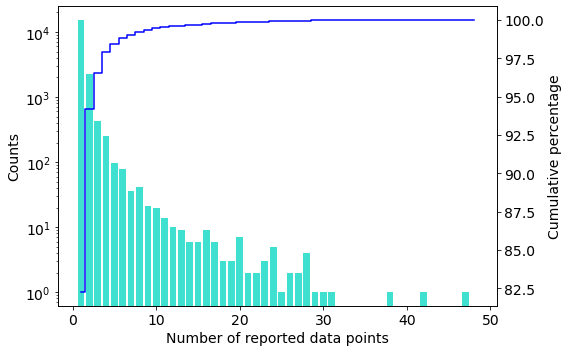

In [121]:
fig, ax = plt.subplots(figsize=(8, 5))
ax2 = ax.twinx()
ax.bar(base[:-1], values, log=True, color='turquoise')
# ax.hist(all_n_pts, log=True, color='turquoise', bins=bins)
ax2.step(base[:-1], cumulative, c='blue', where='mid')
ax.set_ylabel("Counts", fontsize=14)
ax2.set_ylabel("Cumulative percentage", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlabel("Number of reported data points", fontsize=14)
fig.tight_layout()
fig.show()
fig.savefig('figures/data_point_distribution.png', dpi=150)

In [115]:
values

array([15291,  2224,   432,   251,    97,    78,    36,    41,    21,
          20,    14,    10,     9,     6,     6,     9,     6,     3,
           3,     7,     2,     2,     3,     5,     1,     2,     2,
           4,     1,     1,     1,     0,     0,     0,     0,     0,
           0,     1,     0,     0,     0,     1,     0,     0,     0,
           0,     1,     0])

In [117]:
cumulative

array([0.82249476, 0.94212253, 0.96535958, 0.97886074, 0.98407832,
       0.9882739 , 0.99021032, 0.99241569, 0.99354526, 0.99462105,
       0.99537411, 0.995912  , 0.99639611, 0.99671884, 0.99704158,
       0.99752568, 0.99784842, 0.99800979, 0.99817116, 0.99854768,
       0.99865526, 0.99876284, 0.99892421, 0.99919316, 0.99924695,
       0.99935453, 0.99946211, 0.99967726, 0.99973105, 0.99978484,
       0.99983863, 0.99983863, 0.99983863, 0.99983863, 0.99983863,
       0.99983863, 0.99983863, 0.99989242, 0.99989242, 0.99989242,
       0.99989242, 0.99994621, 0.99994621, 0.99994621, 0.99994621,
       0.99994621, 1.        , 1.        ])